In [58]:
import shapely
from shapely import wkt
from shapely import (
    Point, 
    MultiPoint, 
    Polygon, 
    MultiPolygon, 
    LineString, 
    MultiLineString,
    GeometryCollection
)

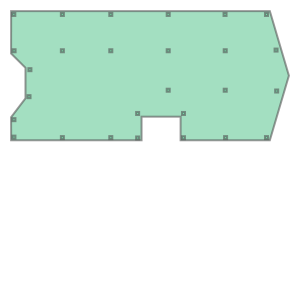

In [59]:
with open("slab_outline.wkt", 'r') as file:
    slab_outline = wkt.load(file)
with open("columns.wkt", 'r') as file:
    columns = wkt.load(file)
    
# Omit columns 20-21 to make room for a wall
column_list = list(columns.geoms)
columns_subset = column_list[:19] + column_list[21:]
GeometryCollection([slab_outline, *columns_subset])


In [60]:
# Before I make a wall (manually) I need to find out where it should go
# Will look at coords of the columns I omitted

col1, col2 = column_list[20:22]
display(list(col1.exterior.coords))
display(list(col2.exterior.coords))


[(19802.069305555553, 14146.896888888887),
 (19802.069305555553, 14446.899111111108),
 (20102.071527777774, 14446.899111111108),
 (20102.071527777774, 14146.896888888887),
 (19802.069305555553, 14146.896888888887)]

[(25461.17166666666, 14146.896888888887),
 (25461.17166666666, 14446.899111111108),
 (25761.173888888883, 14446.899111111108),
 (25761.173888888883, 14146.896888888887),
 (25461.17166666666, 14146.896888888887)]

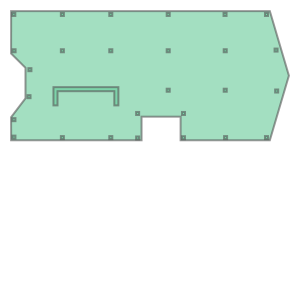

In [61]:
wall_center_line = LineString([(14500, 13000), (14500, 14400), (20500, 14400), (20500, 13000)])
c_wall_400 = wall_center_line.buffer(200, cap_style='square', join_style='mitre')
walls = [c_wall_400]
GeometryCollection([slab_outline, *columns_subset, c_wall_400])

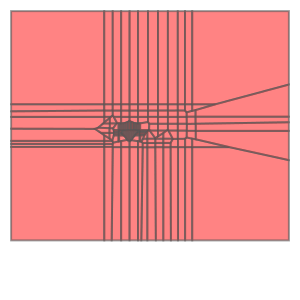

In [62]:
import more_itertools # This library is included in PfSE. Look it up on PyPI for docs (useful)

# Make sure the first/last point is not duplicated in the list
column_points = [list(column.exterior.coords)[:-1] for column in columns_subset]

# Break up wall in to smaller segments according to a maximum segment length
max_seg_length = 300
walls = [c_wall_400]
segmented_walls = [
    Polygon(shapely.segmentize(wall.exterior, max_seg_length))
    for wall in walls
]
wall_points = [list(wall.exterior.coords)[:-1] for wall in segmented_walls]

grouped_points = column_points + wall_points
flattened_points = list(more_itertools.flatten(grouped_points))

voronoi_source = MultiPoint(flattened_points)
v_polys = shapely.voronoi_polygons(voronoi_source)
v_polys

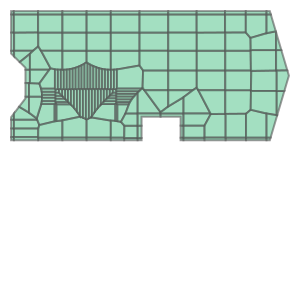

In [63]:
trib_components = [slab_outline & v_poly for v_poly in v_polys.geoms]
GeometryCollection(trib_components)

In [64]:
reordered_components = []
for point in flattened_points: # Iterate by points to prioritize point order
    for poly in trib_components:
        if poly.contains(Point(point)):
            reordered_components.append(poly)

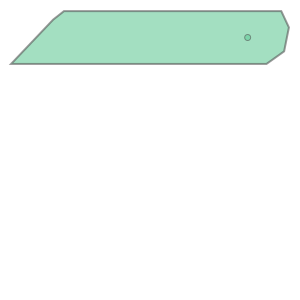

In [65]:
idx = 140
display(GeometryCollection([reordered_components[idx], Point(flattened_points[idx])]))

In [66]:
all_polygons = columns_subset + segmented_walls

poly_lookup = {}
for idx, point_group in enumerate(grouped_points):
    for point in point_group:
        poly_lookup.update({point: all_polygons[idx]})

In [67]:
trib_lookup = {}
for idx, trib_component in enumerate(reordered_components):
    corresponding_point = flattened_points[idx]
    corresponding_polygon = poly_lookup[corresponding_point]
    trib_component_list = trib_lookup.get(corresponding_polygon, [])
    trib_component_list.append(trib_component)
    trib_lookup[corresponding_polygon] = trib_component_list

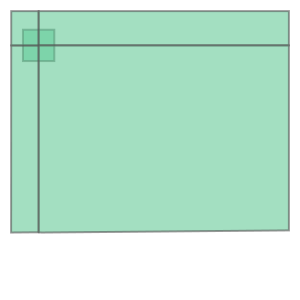

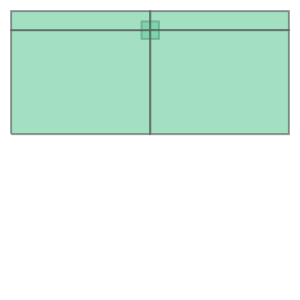

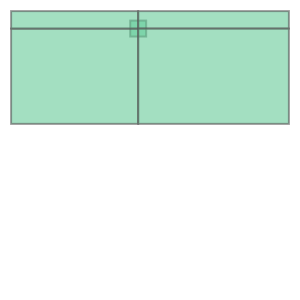

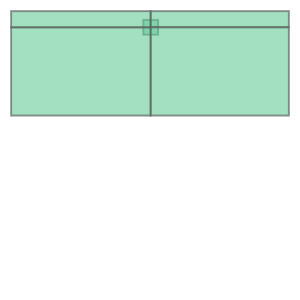

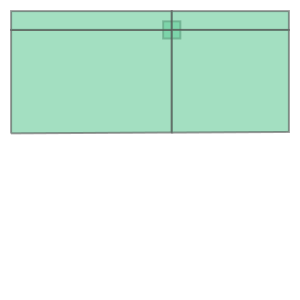

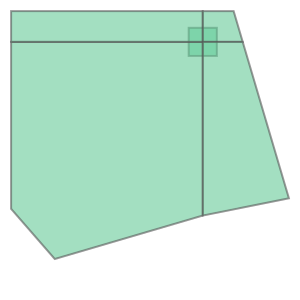

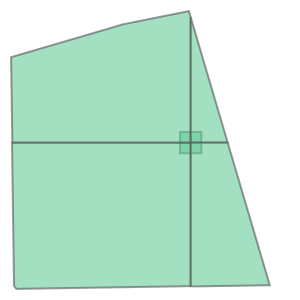

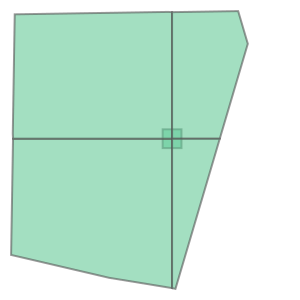

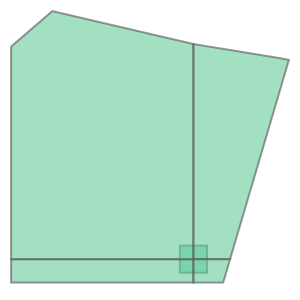

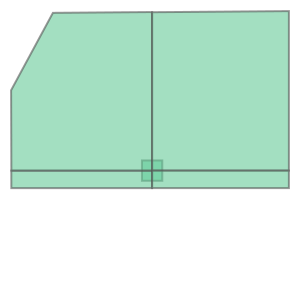

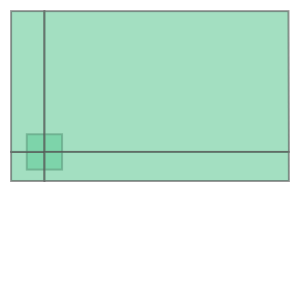

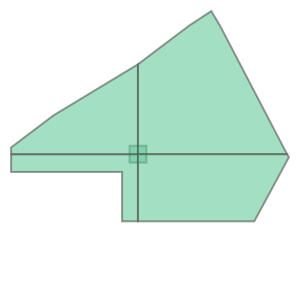

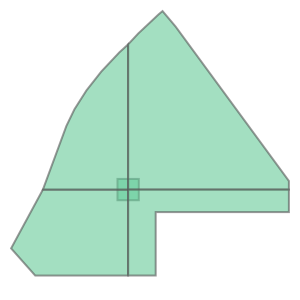

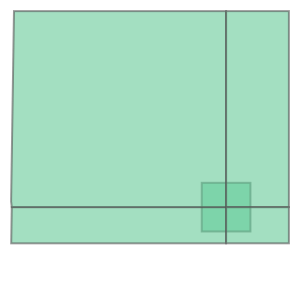

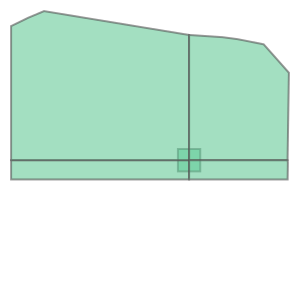

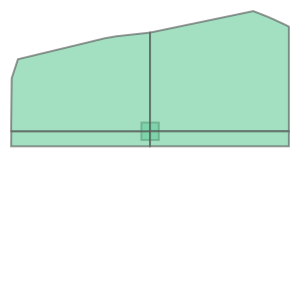

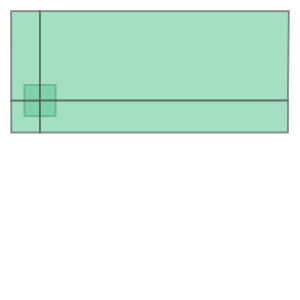

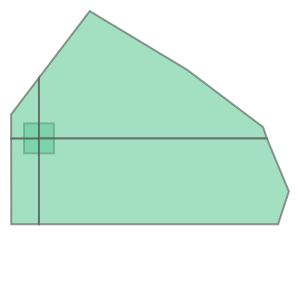

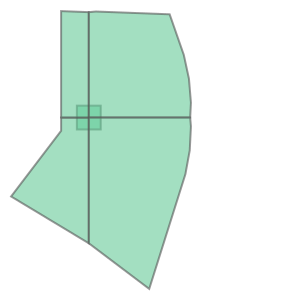

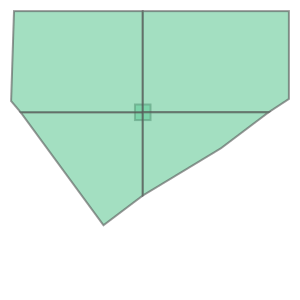

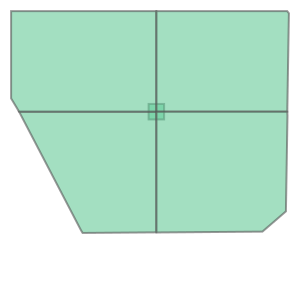

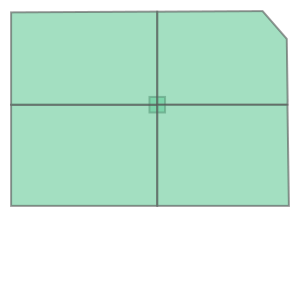

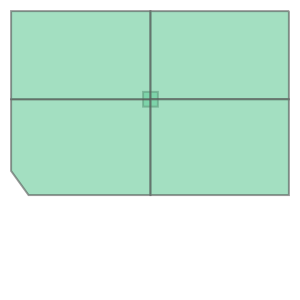

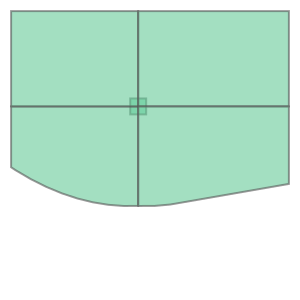

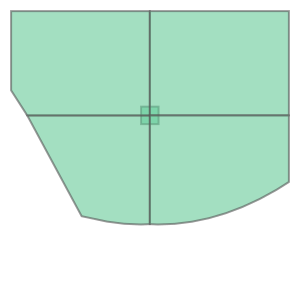

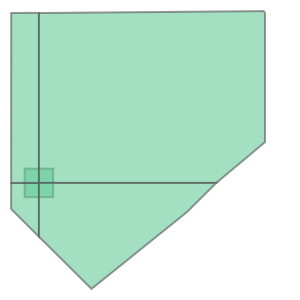

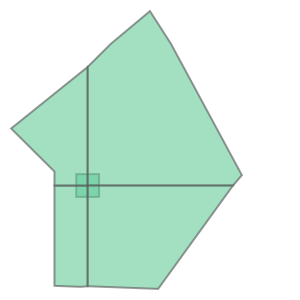

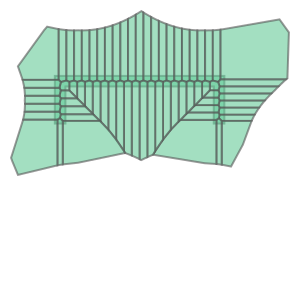

In [68]:
trib_area_lookup = {}
for polygon, trib_components in trib_lookup.items():
    trib_area_lookup[polygon] = shapely.unary_union(trib_components)
    display(GeometryCollection([polygon, *trib_components]))

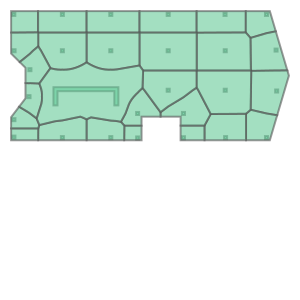

In [69]:
trib_areas = trib_area_lookup.values()
source_geometry = trib_area_lookup.keys()
GeometryCollection([*source_geometry, *trib_areas])